In [37]:
import torch.nn as nn
import os
import torch
from torch.utils.data import Dataset
from PIL import Image
import torchvision.transforms as T
from torch.utils.data import DataLoader, random_split
import matplotlib.pyplot as plt

In [38]:
dataset_root = r"C:\Users\yuval\.cache\kagglehub\datasets\mateuszbuda\lgg-mri-segmentation\versions\2\kaggle_3m"
class ConvBlock(nn.Module):
    def __init__(self, in_c, out_c):
        super().__init__()
        self.block = nn.Sequential(
            nn.Conv2d(in_c, out_c, 3, padding=1),
            nn.BatchNorm2d(out_c), # normalize the data -> how many standard deviations
            nn.ReLU(inplace=True),
            nn.Conv2d(out_c, out_c, 3, padding=1), # apply another conv (while keeping channel dim) to enrich the output.
            nn.BatchNorm2d(out_c),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        return self.block(x)

class Encoder(nn.Module):
    def __init__(self):
        super().__init__()
        self.enc1 = ConvBlock(1, 64)
        self.enc2 = ConvBlock(64, 128)
        self.enc3 = ConvBlock(128, 256)
        self.enc4 = ConvBlock(256, 512)
        self.pool = nn.MaxPool2d(2)

    def forward(self, x):
        # convolve 256 -> 256 (no pooling)
        x1 = self.enc1(x)
        # down 256 -> 128
        x2 = self.enc2(self.pool(x1))
        # down 128 -> 64
        x3 = self.enc3(self.pool(x2))
        # down 64 -> 32
        x4 = self.enc4(self.pool(x3))
        return x1, x2, x3, x4

class TransformerBottleneck(nn.Module):
    def __init__(self, dim, num_heads=8, num_layers=4, spatial_res=32):
        super().__init__()
        self.pos_embed = nn.Parameter(torch.zeros(1, spatial_res**2, dim)) # learnable pos embeddings
        nn.init.trunc_normal_(self.pos_embed, std=0.02) # init with normal dist

        encoder_layer = nn.TransformerEncoderLayer(d_model=dim, nhead=num_heads, batch_first=True, dropout=0.1, activation='gelu')
        self.transformer = nn.TransformerEncoder(encoder_layer, num_layers=num_layers) # 'num_layers' size transformer

    def forward(self, x):
        B, C, H, W = x.shape
        x = x.flatten(2).transpose(1, 2) # squashes the input into a vector to feed the transformer
        x = x + self.pos_embed
        x = self.transformer(x)
        x = x.transpose(1, 2).view(B, C, H, W) # return to image form
        return x

class Decoder(nn.Module):
    def __init__(self):
        super().__init__()
        # up 32 -> 64
        self.up1 = nn.ConvTranspose2d(512, 256, 2, stride=2)
        self.conv1 = ConvBlock(512, 256)
        # up 64 -> 128
        self.up2 = nn.ConvTranspose2d(256, 128, 2, stride=2)
        self.conv2 = ConvBlock(256, 128)
        # up 128 -> 256
        self.up3 = nn.ConvTranspose2d(128, 64, 2, stride=2)
        self.conv3 = ConvBlock(128, 64)
        # the predicted map 256 -> 256
        self.out = nn.Conv2d(64, 1, kernel_size=1)

    def forward(self, bottleneck_out, x3, x2, x1):
        x = self.up1(bottleneck_out)
        x = torch.cat([x, x3], dim=1)
        x = self.conv1(x)

        x = self.up2(x)
        x = torch.cat([x, x2], dim=1)
        x = self.conv2(x)

        x = self.up3(x)
        x = torch.cat([x, x1], dim=1)
        x = self.conv3(x)

        return self.out(x)

class TumorDetector(nn.Module):
    def __init__(self, img_size=256, u_depth=3):
        super().__init__()
        self.encoder = Encoder()
        self.transformer = TransformerBottleneck(dim=512, spatial_res=img_size // 2**u_depth)
        self.decoder = Decoder()

    def forward(self, x):
        x1, x2, x3, x4 = self.encoder(x)
        bottleneck_out = self.transformer(x4)
        mask_logits = self.decoder(bottleneck_out, x3, x2, x1)
        return mask_logits

In [39]:
class MRIDataset(Dataset):
    def __init__(self, root_dir, limit=20, img_size=256):
        self.samples = []
        self.img_size = img_size

        # take the MRI scans, resize then and convert to tensor
        self.transform_img = T.Compose([
            T.Resize((img_size, img_size)),
            T.ToTensor(),
        ])

        # use Interpolation Mode NEAREST for masks (ground truth images) to avoid creating "blurry" pixels during resizing
        self.transform_mask = T.Compose([
            T.Resize((img_size, img_size), interpolation=T.InterpolationMode.NEAREST),
            T.ToTensor(),
        ])

        i = 0
        # look into all patient folders
        for patient in os.listdir(root_dir):

            if limit and i >= limit: # allows to look into only a specific amount of patients for debugging
                break

            patient_dir = os.path.join(root_dir, patient)

            if not os.path.isdir(patient_dir):
                continue

            # find all images and pair them with their ground truth (mask)
            for fname in os.listdir(patient_dir):
                if fname.endswith(".tif") and not fname.endswith("_mask.tif"):
                    img_path = os.path.join(patient_dir, fname)
                    mask_path = img_path.replace(".tif", "_mask.tif")

                    if os.path.exists(mask_path):
                        self.samples.append((img_path, mask_path))
            i += 1

            # now the samples array is stored as [MRI Image 1, Ground Truth 1, MRI Image 2, Ground Truth 2, ....]

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        img_path, mask_path = self.samples[idx]

        # load as Grayscale to get rid of redundant information
        image = Image.open(img_path).convert("L")
        mask = Image.open(mask_path).convert("L")

        # apply transforms
        image = self.transform_img(image)
        mask = self.transform_mask(mask)

        # ensure mask is strictly binary (0 or 1)
        # we use a threshold because T.ToTensor() scales pixels to [0, 1]
        mask = (mask > 0.1).float()

        return image, mask

In [40]:
def dice_score(outputs, targets, eps=1e-6):
    probs = torch.sigmoid(outputs)
    preds_bin = (probs > 0.5).float()
    intersection = (preds_bin * targets).sum() # |A cross B|
    union = preds_bin.sum() + targets.sum() # |A u B|
    return (2 * intersection + eps) / (union + eps)

def dice_loss(outputs, targets, eps=1e-6):
    probs = torch.sigmoid(outputs)
    intersection = (probs * targets).sum(dim=(1, 2, 3))
    union = probs.sum(dim=(1, 2, 3)) + targets.sum(dim=(1, 2, 3))
    dice = (2.0 * intersection + eps) / (union + eps)
    return 1.0 - dice.mean()

In [44]:
dataset = MRIDataset(dataset_root, limit=None)

# split: 80% train, 20% validation
val_size = int(0.2 * len(dataset))
train_size = len(dataset) - val_size
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

# create DataLoaders
val_loader = DataLoader(val_dataset, batch_size=16, shuffle=True, num_workers=0, pin_memory=True)
device = "cuda" if torch.cuda.is_available() else "cpu"
print(device)
model = TumorDetector().to(device)
state_dict = torch.load(r'C:\Users\yuval\PyCharmMiscProject\models\brain_tumor_model_v2\brain_tumor_model_v2.pth', weights_only=True)
model.load_state_dict(state_dict)

cuda


<All keys matched successfully>

In [49]:
# Validation
model.eval()
val_h_dice = 0

saved_samples = None # storing the first batch to visualize in the next cell

with torch.no_grad():
    for i, (images, masks) in enumerate(val_loader):
        images, masks = images.to(device), masks.to(device)

        with torch.amp.autocast('cuda'):
            outputs = model(images)

        # calc metrics
        h_dice = dice_score(outputs, masks)
        val_h_dice += h_dice
        probs = torch.sigmoid(outputs)

        if i == 0: # storing the first batch to visualize in the next cell
            saved_samples = {
                'images': images.cpu(),
                'masks': masks.cpu(),
                'probs': probs.cpu()
            }

avg_val_dice = val_h_dice / len(val_loader)

# final summary
print(f"Validation Complete.")
print(f"Avg Val Dice: {avg_val_dice:.4f}")

Validation Complete.
Avg Val Dice: 0.8656


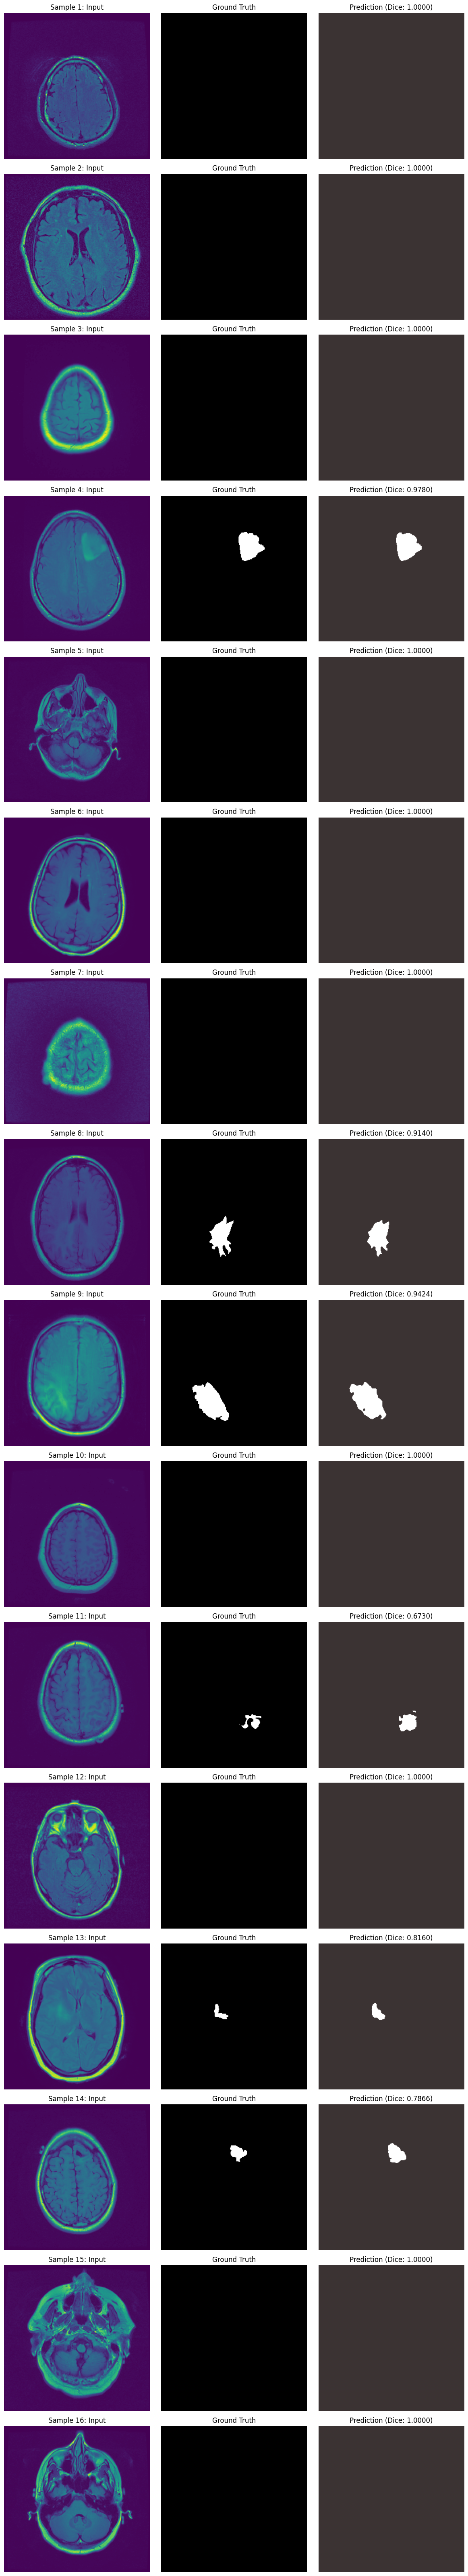

In [50]:
# Visualize a batch
def calculate_dice(pred, target, eps=1e-6):
    """Calculates the Dice score for a single image/mask pair."""
    # flatten both tensors to 1D
    pred_flat = pred.view(-1)
    target_flat = target.view(-1)

    intersection = (pred_flat * target_flat).sum()
    return (2. * intersection + eps) / (pred_flat.sum() + target_flat.sum() + eps)

if saved_samples is not None:
    num_to_show = 16
    fig, axes = plt.subplots(num_to_show, 3, figsize=(12, 4 * num_to_show))

    for idx in range(num_to_show):
        # input Image
        img = saved_samples['images'][idx].permute(1, 2, 0)
        axes[idx, 0].imshow(img)
        axes[idx, 0].set_title(f"Sample {idx+1}: Input")

        # GT Mask
        gt_mask = saved_samples['masks'][idx].squeeze()
        axes[idx, 1].imshow(gt_mask, cmap='gray')
        axes[idx, 1].set_title("Ground Truth")

        # model prediction
        # Convert probabilities to binary mask (0 or 1)
        prob_mask = saved_samples['probs'][idx].squeeze()
        pred_mask = (prob_mask > 0.5).float()

        current_dice = calculate_dice(pred_mask, gt_mask)

        axes[idx, 2].imshow(pred_mask, cmap='hot', alpha=0.8)
        axes[idx, 2].set_title(f"Prediction (Dice: {current_dice:.4f})")

        for ax in axes[idx]:
            ax.axis('off')

    plt.tight_layout()
    plt.show()